In [2]:
!pip install pymysql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00


In [ ]:
# -*- encoding: utf-8 -*-
'''
@File      :data_preprocess.ipynb
@Description  :Conducted statistical analysis and feature selection, use a piece of data to build LSTM model and test
@Time      :2023/05/10
@Author     :yaowen
@Version    :1.0
'''
import pandas as pd
import numpy as np
import pymysql
import os
import matplotlib.pyplot as plt
import warnings
import dask.dataframe as dd

warnings.filterwarnings('ignore')


def dbFecth(Sql, DBconfig):
    """
    @Description:    read my sql database
    @Param Sql:     SQL Query
    @Param DBconfig:  the information of sql database
    @Returns:      dict with columns'name
    """

    conn = pymysql.connect(**DBconfig)
    # return dict
    cursor = conn.cursor(cursor=pymysql.cursors.DictCursor)
    cursor.execute(Sql)
    data = cursor.fetchall()
    conn.commit()
    cursor.close()
    conn.close()
    return data


def dbIns(Sql, DBconfig, DataList):

    """
    @Description:      Insert SQL database
    @Param Sql:        SQL Query
    @Param DBconfig:   the information of sql database
    @Param DataList:   the insert data. The type is a list of tuple elements
    @Returns     :
    """

    conn = pymysql.connect(**DBconfig)
    cursor = conn.cursor()
    with cursor,conn:
        # cursor.execute(Sql, DataList)
        cursor.executemany(Sql, DataList)
        conn.commit()
        cursor.close()
        conn.cursor()


DBconfig = {}



sql1 = "select DATE_FORMAT(subdate(time, interval x minute),'%Y-%m-%d %H:%i') AS time, xxx from xxx where xxx and time BETWEEN '' AND '' order by time desc;"
sql2 = "SELECT DATE_FORMAT(time,'%Y-%m-%d %H:%i') AS xxx from xxx where xxx and time BETWEEN '' AND '' order by time desc"

data = pd.DataFrame(dbFecth(sql1, DBconfig))
dataph = pd.DataFrame(dbFecth(sql2, DBconfig))
print(data) #here record the number of data
print(dataph)
#it will be the time series data
# time     feature1 feature2  feature3  feature4  feature5
#2023-07-12 09:58  5   6    591.826   53.548  185.998


In [ ]:
# Converts the time column to the date-time type

data['time'] = pd.to_datetime(data['time'])
dataph['time'] = pd.to_datetime(dataph['time'])
datapre= pd.merge(data, dataph, on='time')
datapre.iloc[:, 1:] = datapre.iloc[:, 1:].astype(float)
datapre = datapre.dropna()
datapre.to_csv('data.csv', index=False)
print(datapre)


## Outlier processing: Use statistical tests and box plots to check the data distribution and conduct appropriate processing

In [ ]:
statistics = datapre.describe()
print(statistics)

mean = datapre['target'].mean()
std = datapre['target'].std()
skewness = datapre['target'].skew()
kurtosis = datapre['target'].kurtosis()

# print
print("mean：", mean)
print("std：", std)
print("skewness：", skewness)
print("kurtosis：", kurtosis)



In [ ]:
columns_to_process = ['feature1', 'feature2', 'feature3']

# calculate Z-score
z_scores = (datapre[columns_to_process] - datapre[columns_to_process].mean()) / datapre[columns_to_process].std()
# define the outliers（exZ-score>3 is regarded as outliers）
threshold = 3
# remove
has_outliers = (z_scores.abs() > threshold).any(axis=1)
datapre = datapre[~has_outliers]
print(datapre)


## Feature engineering: Some transformation of the original feature: (Sliding average of water onsumption per ton), Different features depending on the business mix and so on.

### For some reasons, I can't share the detail of here. But I will do something like:


In [ ]:
#
datapre['feature_per'] = datapre['feature1'] / datapre['featuer2']
datapre['feature3_mean'] = datapre['feature3'].rolling(1).mean()
datapre['feature4'] = datapre['feature4'].apply(lambda x: 1 if x>0 else 0)

In [ ]:
corr_matrix_raw = datapre.corr()

# Display the correlation of the features with feature
corr_matrix_raw['feature'].sort_values(ascending=False)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

def prefeature(datapre):
  datapre = datapre.replace([np.inf, -np.inf], np.nan)

  # Convert the data type to float64 and ignore the NaN value
  columns_to_convert = []
  datapre[columns_to_convert] = datapre[columns_to_convert].astype('float', errors='ignore')
  datapre = datapre.dropna()

  y = datapre[['']]
  X = datapre[['']]


  # feature scaling
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(X)


  # Generated polynomial feature
  poly = PolynomialFeatures(2)
  poly_data = poly.fit_transform(scaled_data)
  #print(poly_data)
  # feature selection
  selector = SelectKBest(f_regression, k=10)
  selected_data = selector.fit_transform(poly_data, y)

  # Outputs the selected feature column
  selected_cols = selector.get_support(indices=True)
  print("Selected features: ", selected_cols)
  print(selected_data)
  print(y)
  return scaler, poly, selector, selected_data, y
"""
Print output
Selected features:  [ 2  4  7  9 17 24 30 33 42 43]
[[-0.4921934  -0.67566101 -0.84202857 ...  0.56892587  0.70901211
   1.15894397]
 [-0.4921934  -0.57584206 -0.7924826  ...  0.45634481  0.62802867
   1.09075032]
 [-0.4921934  -0.580833   -0.74869779 ...  0.43486839  0.56054838
   1.03048616]
 ...
 [-2.24777061 -0.88528081 -0.66285652 ...  0.58681416  0.43937877
   0.91233671]
 [-2.24777061 -0.86531702 -0.64154024 ...  0.55513568  0.41157387
   0.88299758]
 [-2.24777061 -0.82039849 -0.62828957 ...  0.51544782  0.39474778
   0.86475974]]
"""
scaler, poly, selector, selected_data, y = prefeature(datapre)

In [ ]:
#!pip install torch==1.8.1+cpu torchvision==0.9.1+cpu torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Epoch: 30, Loss: 0.41864126920700073, Train MAE: 0.5024815797805786, Val MAE: 1.3526540994644165, Train RMSE: 0.647024929523468, Val RMSE: 1.5113086700439453
Epoch: 60, Loss: 0.3834342062473297, Train MAE: 0.4745267927646637, Val MAE: 0.5379812121391296, Train RMSE: 0.6192206144332886, Val RMSE: 0.6943404674530029
Epoch: 90, Loss: 0.38113364577293396, Train MAE: 0.4729118347167969, Val MAE: 0.4597807228565216, Train RMSE: 0.6173602342605591, Val RMSE: 0.605148434638977
Epoch: 120, Loss: 0.378785640001297, Train MAE: 0.4719940721988678, Val MAE: 0.4572546184062958, Train RMSE: 0.615455687046051, Val RMSE: 0.6022468209266663
Epoch: 150, Loss: 0.3815794587135315, Train MAE: 0.4739360511302948, Val MAE: 0.4571485221385956, Train RMSE: 0.6177211403846741, Val RMSE: 0.6021165251731873
Epoch: 180, Loss: 0.382470965385437, Train MAE: 0.4727576673030853, Val MAE: 0.45709577202796936, Train RMSE: 0.6184423565864563, Val RMSE: 0.6020466685295105
Epoch: 210, Loss: 0.38081681728363037, Train MAE: 0

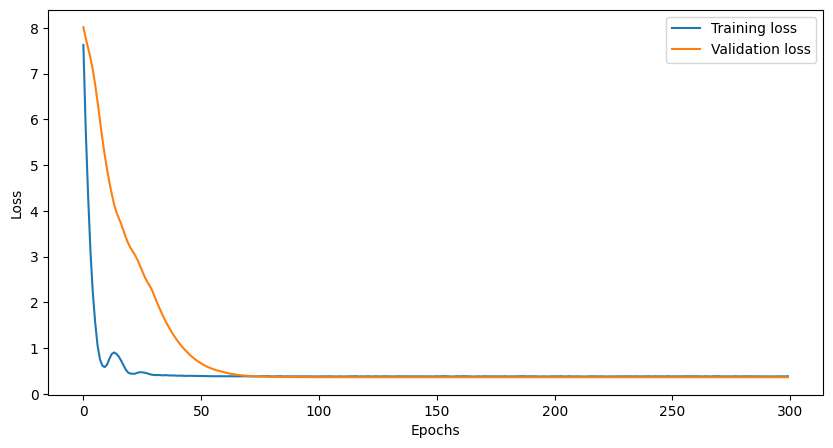

In [23]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch.nn.functional as F
#plt.rcParams['font.sans-serif'] = ['Arial']
#plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
X_train, X_test, y_train, y_test = train_test_split(selected_data, y, test_size=0.2, shuffle=False)
X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(1)  # Add a new dimension
y_train_tensor = torch.from_numpy(y_train.values).float().view(-1,1)  # change the shape
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

train_losses = []
val_losses = []
train_mae_scores = []
val_mae_scores = []
train_rmse_scores = []
val_rmse_scores = []
# X_train_tensor and X_val_tensor shape: (batch_size, 1, num_features)

# define LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)  # add dropout
        self.fc1 = nn.Linear(hidden_size, hidden_size)  # add new layer
        self.bn = nn.BatchNorm1d(hidden_size)  # Batch normalization
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])  # add new layer
        out = self.bn(out)  # Batch normalization
        out = F.relu(out)  # Nonlinear activation function
        out = self.fc2(out)
        return out

# Hyperparameter definition
input_size = 10 # #feature
hidden_size = 64
output_size = 1
num_layers = 2

# Model initialization
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# Loss functions and optimizers
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.005)  # Increased weight attenuation
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)



# train code
for epoch in range(300):  # epoch
    model.zero_grad()
    outputs = model(X_train_tensor)  # transfer to Tensor
    loss = criterion(outputs, y_train_tensor)  # Use the target variable converted to Tensor
    loss.backward()
    optimizer.step()
    scheduler.step()
    train_mae = mean_absolute_error(y_train_tensor.detach().numpy(), outputs.detach().numpy())
    train_rmse = mean_squared_error(y_train_tensor.detach().numpy(), outputs.detach().numpy(), squared=False)
    train_mae_scores.append(train_mae)
    train_rmse_scores.append(train_rmse)


    # Calculate the verification set loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

        val_mae = mean_absolute_error(y_val_tensor.detach().numpy(), val_outputs.detach().numpy())
        val_rmse = mean_squared_error(y_val_tensor.detach().numpy(), val_outputs.detach().numpy(), squared=False)
        val_mae_scores.append(val_mae)
        val_rmse_scores.append(val_rmse)

    model.train()

    # Saving loss value
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())


    if (epoch+1) % 30 == 0:  #
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}, Train MAE: {train_mae}, Val MAE: {val_mae}, Train RMSE: {train_rmse}, Val RMSE: {val_rmse}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'lstm_model.pth')